# 1. Understanding Folder Structure

In [5]:
import os

base_dir = os.path.join('./cell_images')

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

# 2. Understanding Data Set

In [7]:
data = pd.read_csv('train.csv')
data.head()

,filename,label
0,C50P11thinF_IMG_20150724_114951_cell_148.png,malaria
1,C112P73ThinF_IMG_20150930_131659_cell_94.png,healthy
2,C59P20thinF_IMG_20150803_111333_cell_144.png,malaria
3,C158P119ThinF_IMG_20151115_181136_cell_202.png,malaria
4,C81P42ThinF_IMG_20150817_120524_cell_190.png,malaria


In [8]:
data['label'].value_counts()

label
malaria    9645
healthy    9645
Name: count, dtype: int64

<Figure size 1500x1500 with 0 Axes>

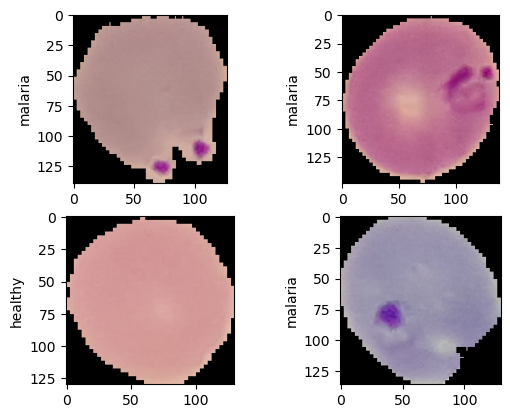

In [13]:
from skimage.io import imread, imshow, imsave

plt.figure(figsize=(15,15))
fig, ax = plt.subplots(nrows=2,ncols=2)

for i in range(2):
    for j in range(2):
        
        image = imread(os.path.join(base_dir,data['filename'][i+2*j]))
        
        ax[i,j].imshow(image)
        ax[i,j].set_ylabel(data['label'][i+2*j])

# 3. Data Preparation

In [16]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(data['label'])

labels = le.transform(data['label'])

In [20]:
labels

array([1, 0, 1, ..., 0, 1, 0])

In [19]:
#import required functions
from sklearn.model_selection import train_test_split

#divide the dataset into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(data['filename'],
                                                                    labels, 
                                                                    test_size=0.2, random_state=42,shuffle=True)
#check the shapes of training and validation sets
print(train_files.shape, val_files.shape)
print(train_labels.shape,val_labels.shape)

(15432,) (3858,)
(15432,) (3858,)


In [21]:
from skimage.io import imread, imshow
from skimage.transform import resize

In [22]:
shapes = []
for i in data['filename']:
    image = imread(os.path.join(base_dir,i))
    shapes.append(image.shape)

print('Minimum Dimensions - ',np.min(shapes,axis=0))
print('Maximum Dimensions - ',np.max(shapes,axis=0))
print('Average Dimensions - ',np.mean(shapes,axis=0))

Minimum Dimensions -  [40 49  3]
Maximum Dimensions -  [385 364   3]
Average Dimensions -  [132.9600311  132.58335925   3.        ]


# 6. Model1: Model building using Pixel Features

In [25]:
IMG_DIMS=(40,40)
train_features_pixel=[]

for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    train_features_pixel.append(features)

train_features_pixel = np.array(train_features_pixel)

In [26]:
train_features_pixel.shape

(15432, 4800)

In [27]:
IMG_DIMS=(40,40)
val_features_pixel=[]

for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    features = np.reshape(image,(IMG_DIMS[0]*IMG_DIMS[1]*3))
    val_features_pixel.append(features)

val_features_pixel = np.array(val_features_pixel)

In [28]:
val_features_pixel.shape

(3858, 4800)

## Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_pixel = LogisticRegression()
clf_lr_pixel.fit(train_features_pixel,train_labels)

LogisticRegression()

In [32]:
preditions_train = clf_lr_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  73.04302747537584 %
Validation: Model Accuracy -  68.14411612234318 %


## Linear SVM

In [33]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_pixel = LinearSVC(random_state=102)
clf_svc_pixel.fit(train_features_pixel,train_labels)

LinearSVC(random_state=102)

In [34]:
preditions_train = clf_svc_pixel.predict(train_features_pixel)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_pixel.predict(val_features_pixel)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  77.77993779160187 %
Validation: Model Accuracy -  68.01451529289787 %


# 7. Method 2: HOG Features

In [35]:
from skimage.feature import hog

In [54]:
#Showing example of one image first
index= np.random.randint(0,1000)

image = imread(os.path.join(base_dir,train_files.iloc[index]))
IMG_DIMS = (128,64) # SkIMAGE takes input in HEIGHT X WIDTH format
image1 = resize(image,IMG_DIMS)
#calculating HOG features
features, hog_image = hog(image1, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2),visualize=True,channel_axis=2)

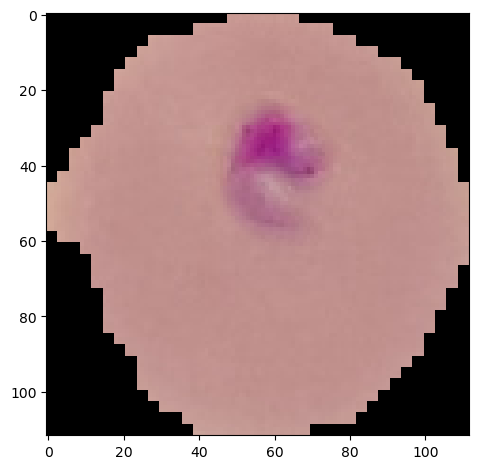

In [55]:
imshow(image)

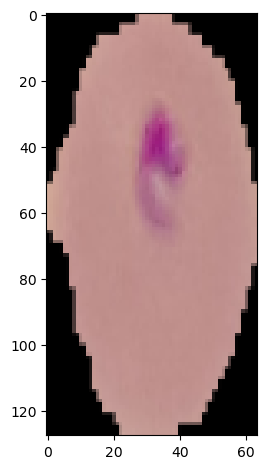

In [56]:
imshow(image1)

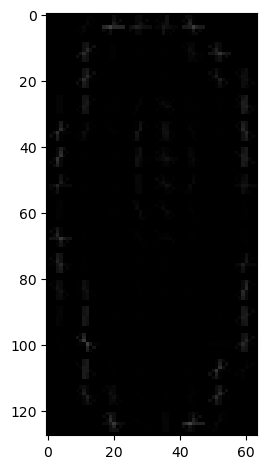

In [57]:
imshow(hog_image)

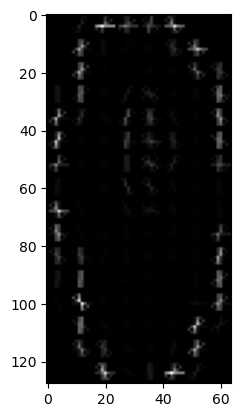

In [58]:
#Highlighting the HOG image using Matplotlib
import matplotlib.pyplot as plt
plt.imshow(hog_image, cmap="gray")

In [59]:
#Shape of HOG Feature Vector
features.shape

(3780,)

## Calculate HOG features for both training and Validation images

In [62]:
IMG_DIMS = (128,64)

#For Training Images

train_features_hog = []
for i in train_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    #calculating HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True,channel_axis=2)
    hog_features = np.reshape(features,(features.shape[0]))
    train_features_hog.append(hog_features)

train_features_hog = np.array(train_features_hog)
  
#For Validation Images

val_features_hog = []
for i in val_files:
    image = imread(os.path.join(base_dir,i))
    image = resize(image,IMG_DIMS)
    #calculating HOG features
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True,channel_axis=2)
    hog_features = np.reshape(features,(features.shape[0]))
    val_features_hog.append(hog_features)

val_features_hog = np.array(val_features_hog)

#checking the shape of the final lists after reading all the images
train_features_hog.shape, val_features_hog.shape

((15432, 3780), (3858, 3780))

# 8. Model2: Model building using HOG Features

## Linear Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

#training the Logistic model
clf_lr_hog = LogisticRegression()
clf_lr_hog.fit(train_features_hog,train_labels)

LogisticRegression()

In [64]:
preditions_train = clf_lr_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_lr_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')

Training: Model Accuracy -  88.95800933125972 %
Validation: Model Accuracy -  81.33748055987559 %


## Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

#training the Logistic model
clf_svc_hog = LinearSVC()
clf_svc_hog.fit(train_features_hog,train_labels)

In [ ]:
preditions_train = clf_svc_hog.predict(train_features_hog)
print("Training: Model Accuracy - ",accuracy_score(train_labels,preditions_train)*100,'%')

predictions_val = clf_svc_hog.predict(val_features_hog)
print("Validation: Model Accuracy - ",accuracy_score(predictions_val,val_labels)*100,'%')